# Levelized Cost of Electricity (LCOE) Prediction Project
### This notebook builds a machine learning pipeline to predict the Levelized Cost of Electricity (LCOE) based on various economic and technical features.

### 1. Importing Libraries
In this section, we import all necessary libraries for data manipulation, visualization, preprocessing, and machine learning modeling.

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import math
import adaptive_ml_workflow as amlw
import pickle 
import warnings   

warnings.filterwarnings('ignore')

df = pd.read_excel('/Users/saafan/LCOE Dataset.xlsx')

### 2. Data Loading & Initial Exploration
Here, we load the dataset and perform initial exploration to understand its structure, data types, and missing values.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396 entries, 0 to 2395
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Country                         2011 non-null   object 
 1   Country Code                    2011 non-null   object 
 2   Technology                      2011 non-null   object 
 3   year                            2011 non-null   float64
 4   Balance of Systems Cost ($/kW)  556 non-null    float64
 5   Module costs ($/kW)             2010 non-null   float64
 6   Total installed costs ($/kW)    556 non-null    float64
 7   LCOE ($/kWh)                    651 non-null    float64
 8   BidYield                        2010 non-null   float64
 9   Capacity (MW)                   1777 non-null   float64
 10  Production (GWh)                1795 non-null   float64
 11  Region                          2011 non-null   object 
 12  IncomeGroup                     20

In [31]:
df.dtypes


Country                            object
Country Code                       object
Technology                         object
year                              float64
Balance of Systems Cost ($/kW)    float64
Module costs ($/kW)               float64
Total installed costs ($/kW)      float64
LCOE ($/kWh)                      float64
BidYield                          float64
Capacity (MW)                     float64
Production (GWh)                  float64
Region                             object
IncomeGroup                        object
TECHNOLOGY RISK                   float64
WACC                              float64
CF                                float64
dtype: object

In [32]:
df['year'] = df['year'].astype('object')

In [33]:
df.dtypes


Country                            object
Country Code                       object
Technology                         object
year                               object
Balance of Systems Cost ($/kW)    float64
Module costs ($/kW)               float64
Total installed costs ($/kW)      float64
LCOE ($/kWh)                      float64
BidYield                          float64
Capacity (MW)                     float64
Production (GWh)                  float64
Region                             object
IncomeGroup                        object
TECHNOLOGY RISK                   float64
WACC                              float64
CF                                float64
dtype: object

### 3. Dropping Columns That are Not Necessary or Has Multicollinearity

In [34]:
df.drop(columns = ['Country', 'Country Code','Technology' , 'Balance of Systems Cost ($/kW)' , 'Module costs ($/kW)', 'BidYield' , 'Production (GWh)' , 'TECHNOLOGY RISK'], inplace = True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396 entries, 0 to 2395
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          2011 non-null   object 
 1   Total installed costs ($/kW)  556 non-null    float64
 2   LCOE ($/kWh)                  651 non-null    float64
 3   Capacity (MW)                 1777 non-null   float64
 4   Region                        2011 non-null   object 
 5   IncomeGroup                   2011 non-null   object 
 6   WACC                          2396 non-null   float64
 7   CF                            1546 non-null   float64
dtypes: float64(5), object(3)
memory usage: 149.9+ KB


### 4. Dropping NaN Values
Here we should drop all the rows that doesn't have both "LCOE" (Y), and "Total installed costs ($/kW)" (main predictor)

In [36]:
df = df.dropna(subset=['LCOE ($/kWh)', 'Total installed costs ($/kW)'])

In [37]:
df['LCOE ($/kWh)'].value_counts()
df['Total installed costs ($/kW)'].value_counts()

Total installed costs ($/kW)
9941.994543     5
7798.954958     2
13557.265280    2
18253.415170    1
2608.137472     1
               ..
1502.996262     1
1879.267395     1
2357.250894     1
2749.919330     1
1260.291048     1
Name: count, Length: 324, dtype: int64

In [38]:
df[['LCOE ($/kWh)', 'Total installed costs ($/kW)']].isna().sum()

LCOE ($/kWh)                    0
Total installed costs ($/kW)    0
dtype: int64

### 5. Split Data Into Categorical and Numerical, And Some Further Adjustments

In [39]:
Numerical_Variables = df.select_dtypes(include = ['float', 'int']).columns.tolist()
Categorical_Variables = df.select_dtypes(include = ['object', 'category']).columns.tolist()

In [40]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 330 entries, 41 to 1998
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          330 non-null    object 
 1   Total installed costs ($/kW)  330 non-null    float64
 2   LCOE ($/kWh)                  330 non-null    float64
 3   Capacity (MW)                 328 non-null    float64
 4   Region                        330 non-null    object 
 5   IncomeGroup                   330 non-null    object 
 6   WACC                          330 non-null    float64
 7   CF                            328 non-null    float64
dtypes: float64(5), object(3)
memory usage: 23.2+ KB


In [41]:
## will drop 2 rows with NaN values in "CF"
df = df.dropna(subset=['CF'])

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 328 entries, 41 to 1998
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          328 non-null    object 
 1   Total installed costs ($/kW)  328 non-null    float64
 2   LCOE ($/kWh)                  328 non-null    float64
 3   Capacity (MW)                 328 non-null    float64
 4   Region                        328 non-null    object 
 5   IncomeGroup                   328 non-null    object 
 6   WACC                          328 non-null    float64
 7   CF                            328 non-null    float64
dtypes: float64(5), object(3)
memory usage: 23.1+ KB


In [69]:
#capping CF (capacity factor) to 0.10 and 0.25
df['CF'] = df['CF'].clip(lower=0.10, upper=0.25)

### 6. Exploratory Data Analysis (EDA)
We analyze feature distributions, correlations, and relationships with the target variable (LCOE)

In [44]:
df.describe()

,Total installed costs ($/kW),LCOE ($/kWh),Capacity (MW),WACC,CF
count,328.000000,328.000000,328.000000,328.000000,328.000000
mean,3858.068014,0.230752,17799.695549,0.079423,0.140743
std,3799.836121,0.251400,50747.267683,0.035036,0.043657
min,628.950581,0.007181,2.000000,0.034813,0.100000
25%,1176.800585,0.057792,516.250000,0.056718,0.101098
50%,2271.705042,0.117830,3712.800000,0.072696,0.128103
75%,5482.438326,0.301169,13658.607750,0.086516,0.161145
max,20578.666590,1.179520,609920.000000,0.215683,0.250000


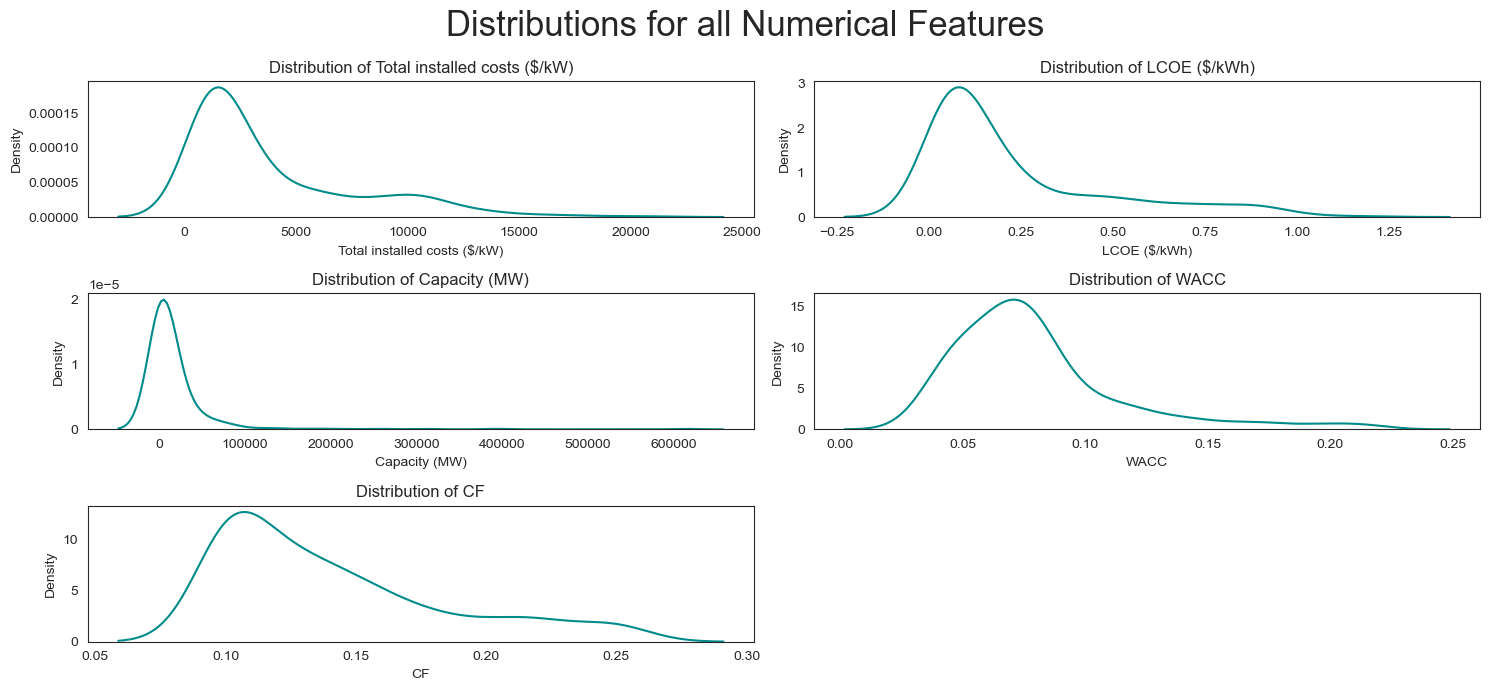

In [45]:
sns.set_style('white')

cols = 2
rows = math.ceil(len(Numerical_Variables) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 7))
fig.suptitle('Distributions for all Numerical Features', size=25)

axes = axes.flatten()

for i, num_var in enumerate(Numerical_Variables):
    sns.kdeplot(df[num_var], ax=axes[i], color='#008B8B')
    axes[i].set_title(f'Distribution of {num_var}', fontsize=12)
    axes[i].set_xlabel(num_var, fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('/Users/saafan/Desktop/GitHub-Portfolio/LCOE Prediction Project/LCOF_Distributions_Numerical_Features.png', dpi=300)
plt.show()


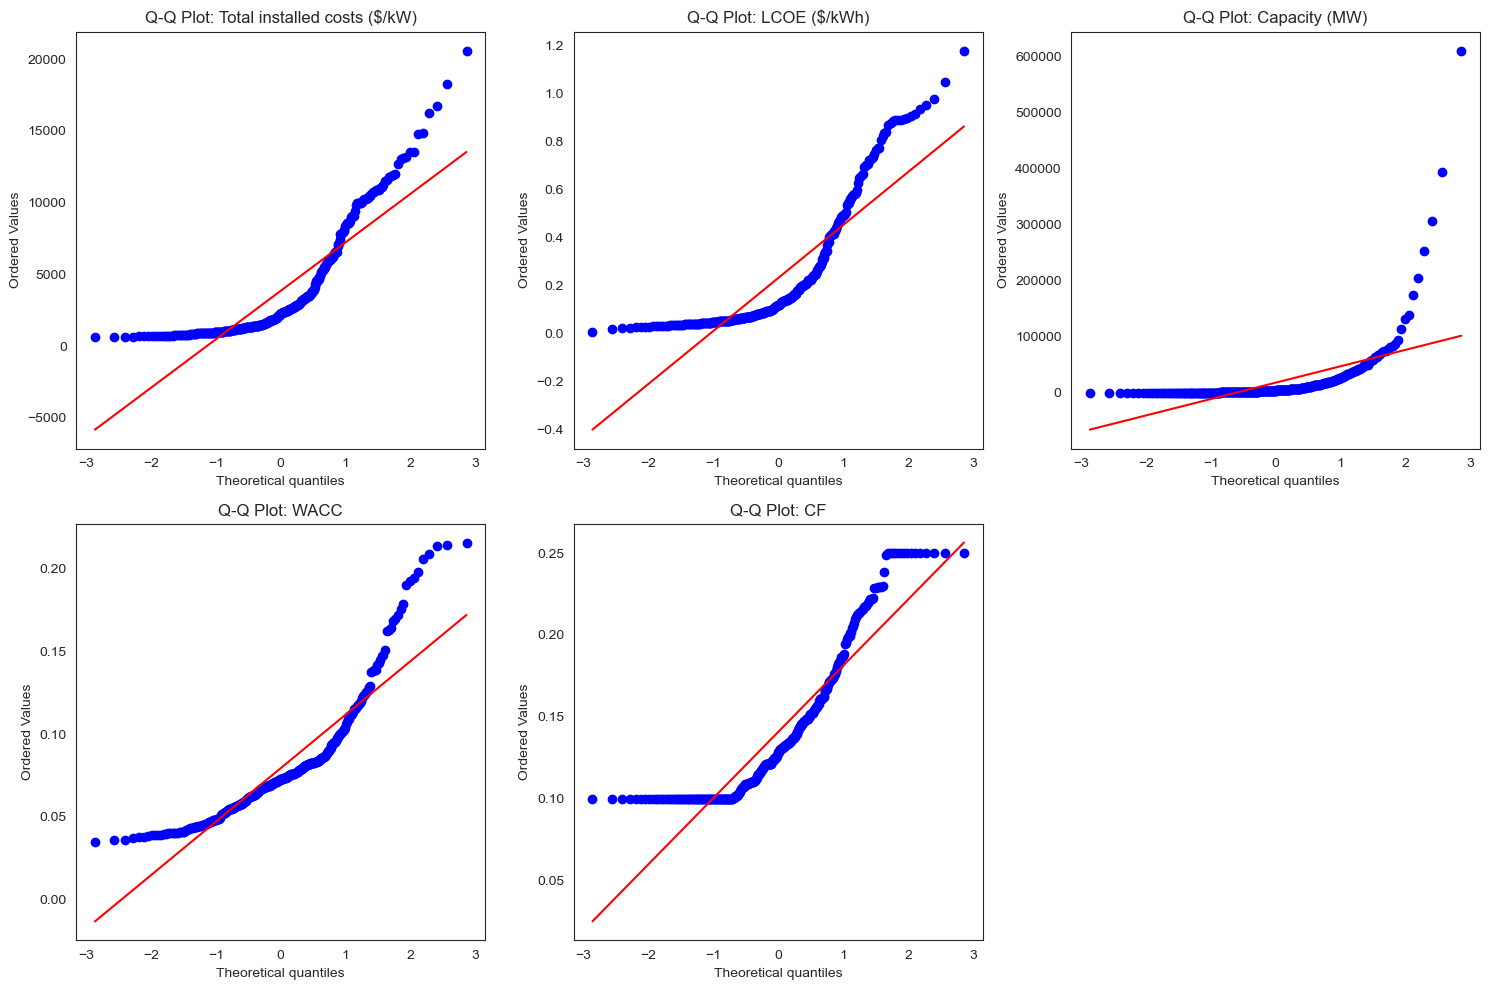

In [46]:
from scipy.stats import probplot

n_rows = 2
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize = (15, 10))
axes = axes.flatten()  # Flatten to easily iterate through axes

for idx, name in enumerate(Numerical_Variables):
    probplot(df[name], dist = "norm", plot = axes[idx])
    axes[idx].set_title(f"Q-Q Plot: {name}")

for i in range(len(Numerical_Variables), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('/Users/saafan/Desktop/GitHub-Portfolio/LCOE Prediction Project/LCOF_QQ_Plots_Numerical_Features.png', dpi=300)
plt.show()

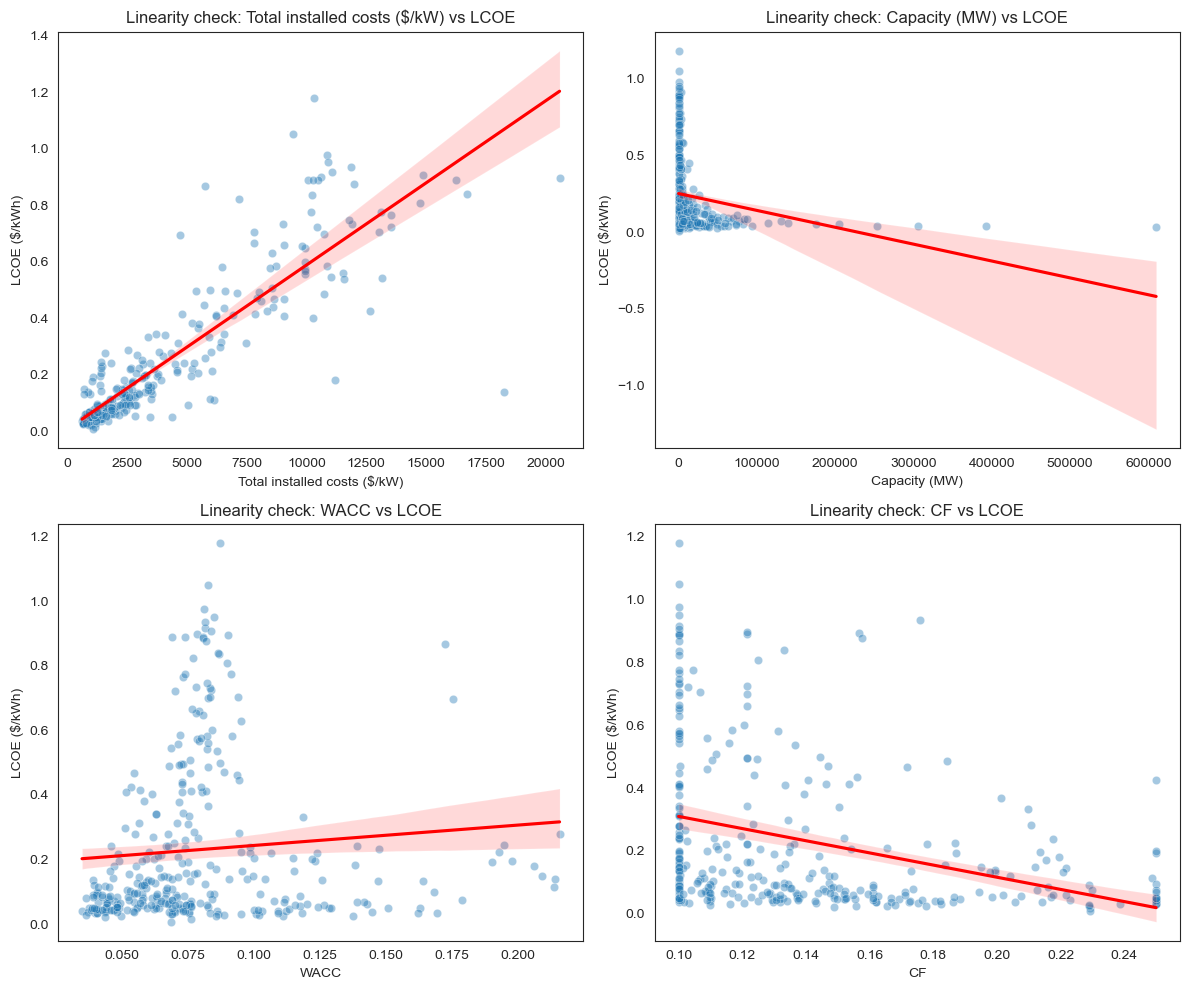

In [71]:
y = df['LCOE ($/kWh)']

Numerical_Variables = ['Total installed costs ($/kW)', 'Capacity (MW)', 'WACC', 'CF']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, var in enumerate(Numerical_Variables):
    sns.scatterplot(x=df[var], y=y, ax=axes[i], alpha=0.4)
    sns.regplot(x=df[var], y=y, scatter=False, color='red', ax=axes[i])
    axes[i].set_title(f'Linearity check: {var} vs LCOE')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('LCOE ($/kWh)')

plt.tight_layout()

plt.savefig('/Users/saafan/Desktop/GitHub-Portfolio/LCOE Prediction Project/LCOF_Linearity_Check_All_Variables.png', dpi=300)

plt.show()

### 7. Model Building. Prepare Train/Test, Predictors & Target Variable.

In [48]:
X = df.drop(columns = ['LCOE ($/kWh)'])
y = df['LCOE ($/kWh)']

In [49]:
X.columns


Index(['year', 'Total installed costs ($/kW)', 'Capacity (MW)', 'Region',
       'IncomeGroup', 'WACC', 'CF'],
      dtype='object')

In [50]:
Categorical_variables = X.select_dtypes(include = ['object']).columns.tolist()
Numerical_variables = X.select_dtypes(include = ['int', 'float']).columns.tolist()

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### 8. Hypertune, Train, Test, Validate and Evaluate Different Models
Using "adaptive_ml_workflow", a Pipeline That I've Built Earlier

In [52]:
preprocessor = amlw.preprocessing(Numerical_variables, Categorical_variables)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('outlier_trimmer',
                                                  OutlierTrimmer()),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Total installed costs ($/kW)',
                                  'Capacity (MW)', 'WACC', 'CF']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['year', 'Region', 'IncomeGroup'])])

In [53]:
Testing_Scores_df, Validation_Scores_df, Best_Models, Tuning_Results_df = amlw.Evaluate(X_train, X_test, y_train, y_test, preprocessor, 
                                                                                               classification = False)


Evaluating: OLS
No hyperparameters to tune, using default parameters...
Computing cross-validation scores...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Evaluating on test set...
OLS evaluation complete!

Evaluating: Lasso
Tuning hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Best parameters: {'model__alpha': np.float64(0.042168988591604895)}
Best CV score: -0.1282
Computing cross-validation scores...
Evaluating on test set...
Lasso evaluation complete!

Evaluating: Ridge
Tuning hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Best parameters: {'model__alpha': np.float64(0.6094844859190754)}
Best CV score: -0.0603
Computing cross-validation scores...
Evaluating on test set...
Ridge evaluation complete!

Evaluating: ElasticNet
Tuning hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Best parameters: {'model__alpha': np.float64(0.042168988591604895), 'model__l1_ratio': np.float64(0.9699098521619943)}
Best CV score: -0.1264
Computing cross-validation scores...
Evaluating on test set...
ElasticNet evaluation complete!

Evaluating: Decision Tree
Tuning hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Best parameters: {'model__criterion': 'friedman_mse', 'model__max_depth': 7, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2}
Best CV score: -0.0615
Computing cross-validation scores...
Evaluating on test set...
Decision Tree evaluation complete!

Evaluating: KNN
Tuning hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Best parameters: {'model__metric': 'manhattan', 'model__n_neighbors': 11, 'model__weights': 'distance'}
Best CV score: -0.0574
Computing cross-validation scores...
Evaluating on test set...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


KNN evaluation complete!

Evaluating: SVM
Tuning hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Best parameters: {'model__C': np.float64(6.932635188254582), 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Best CV score: -0.0727
Computing cross-validation scores...
Evaluating on test set...
SVM evaluation complete!

Evaluation Complete!


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### 9. Show Testing and Validation Scores For Each Model

In [56]:
Validation_Scores_df

,Technique,R2_Score,MAE,MSE,RMSE
0,OLS,0.851,0.062,0.009,0.094
1,Lasso,0.537,0.128,0.029,0.169
2,Ridge,0.867,0.060,0.009,0.089
3,ElasticNet,0.549,0.126,0.029,0.167
4,Decision Tree,0.838,0.061,0.011,0.099
5,KNN,0.871,0.057,0.008,0.089
6,SVM,0.847,0.073,0.010,0.097


In [57]:
Validation_Scores_df.sort_values(by='MAE', ascending=True)

,Technique,R2_Score,MAE,MSE,RMSE
5,KNN,0.871,0.057,0.008,0.089
2,Ridge,0.867,0.060,0.009,0.089
4,Decision Tree,0.838,0.061,0.011,0.099
0,OLS,0.851,0.062,0.009,0.094
6,SVM,0.847,0.073,0.010,0.097
3,ElasticNet,0.549,0.126,0.029,0.167
1,Lasso,0.537,0.128,0.029,0.169


In [58]:
Testing_Scores_df

,Technique,R2_Score,MAE,MSE,RMSE
0,OLS,0.876,0.054,0.008,0.091
1,Lasso,0.515,0.131,0.032,0.180
2,Ridge,0.845,0.060,0.010,0.102
3,ElasticNet,0.528,0.129,0.031,0.177
4,Decision Tree,0.762,0.075,0.016,0.126
5,KNN,0.881,0.054,0.008,0.089
6,SVM,0.839,0.073,0.011,0.103


In [59]:
Testing_Scores_df.sort_values(by='MAE', ascending=True)

,Technique,R2_Score,MAE,MSE,RMSE
0,OLS,0.876,0.054,0.008,0.091
5,KNN,0.881,0.054,0.008,0.089
2,Ridge,0.845,0.060,0.010,0.102
6,SVM,0.839,0.073,0.011,0.103
4,Decision Tree,0.762,0.075,0.016,0.126
3,ElasticNet,0.528,0.129,0.031,0.177
1,Lasso,0.515,0.131,0.032,0.180


### 10. Select and Save Best Model

In [67]:
best_model_name, final_pipeline, model_info = amlw.save_best_model(Testing_Scores_df, Best_Models, X, y,  classification = False)
print(f'Best Model{best_model_name}')
print(f'Final Pipeline {final_pipeline}')
print(f'Model Info {model_info}')


BEST MODEL SELECTION
Best Model: KNN
Best RMSE: 0.089


Model saved as: best_model_KNN.pkl
Best ModelKNN
Final Pipeline Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('outlier_trimmer',
                                                                   OutlierTrimmer()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Total installed costs '
                                                   '($/kW)',
                                                   'Capacity (MW)', 'WACC',
                                                   'CF']),
                   

### 11. Save Model to a File

In [68]:
# Save the model to a file
with open('LCOE_.pkl', 'wb') as file:
    pickle.dump(final_pipeline, file)